# E-commerce text dataset using Chi-square

In [1]:
# File system manangement
import os

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Train-test split, cross validation and feature selections
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.feature_selection import SelectKBest, chi2

# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

# Model evaluation
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [2]:
# Loading the normalized data
data = pd.read_csv('E-commerce_Dataset_Normalized.csv')
print(data.shape)
data

(27802, 2)


,Normalized_Description,Category
0,paper plane design framed wall hanging motivat...,1
1,saf framed painting wood inch x inch special e...,1
2,saf textured modern art print framed painting ...,1
3,saf flower print framed painting synthetic inc...,1
4,incredible gift india wooden happy birthday un...,1
...,...,...
27797,micromax bharat plus zero impact visual displa...,0
27798,microsoft lumia black microsoft lumia experien...,0
27799,microsoft lumia black colourblack product desc...,0
27800,karbonn titanium wind white karbonn titanium w...,0


In [3]:
# Missing values and duplicate observations
print(pd.Series({"Number of observations with missing values": len(data) - len(data.dropna()),
                 "Number of duplicate observations": data.duplicated().sum()}).to_string())

Number of observations with missing values      0
Number of duplicate observations              468


In [4]:
# Dropping duplicate observations
data.drop_duplicates(inplace = True) 
# Resetting index
data.reset_index(drop = True, inplace = True) 

In [5]:
# Feature-target split
X, y = data.drop('Category', axis = 1), data['Category']

In [6]:
# Train-test split (from complete data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 40)
data_train = pd.concat([X_train, y_train], axis = 1)

# Validation-test split (from test data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
data_val, data_test = pd.concat([X_val, y_val], axis = 1), pd.concat([X_test, y_test], axis = 1)

# Comparison of sizes of training set and test set
values = np.array([len(data_train), len(data_val), len(data_test)])
labels = ['Training set', 'Validation Set', 'Test set']
fig = go.Figure(data = [go.Pie(values = values, labels = labels, hole = 0.5, textinfo = 'percent', title = " ")])
text_title = "Comparison of sizes of training set and test set"
fig.update_layout(height = 500, width = 800, showlegend = True, title = dict(text = text_title, x = 0.5, y = 0.95)) 
fig.show()

In [7]:
# Features and labels
X_train, y_train = data_train['Normalized_Description'].tolist(), data_train['Category'].tolist()
X_val, y_val = data_val['Normalized_Description'].tolist(), data_val['Category'].tolist()
X_test, y_test = data_test['Normalized_Description'].tolist(), data_test['Category'].tolist()

In [8]:
# TF-IDF vectorization
TfidfVec = TfidfVectorizer()
X_train_tfidf = TfidfVec.fit_transform(X_train)
X_val_tfidf = TfidfVec.transform(X_val)
X_test_tfidf = TfidfVec.transform(X_test)

X_train_tfidf.shape

(21867, 72032)

In [9]:
selector = SelectKBest(chi2, k=8000)
X_train_tfidf_selected = selector.fit_transform(X_train_tfidf, y_train)
X_val_tfidf_selected = selector.transform(X_val_tfidf)
X_test_tfidf_selected = selector.transform(X_test_tfidf)

In [10]:
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train_tfidf_selected, y_train)

MultinomialNB()

In [11]:
# Function to return summary of baseline models
def score(X_train, y_train, X_val, y_val):
    score_df, score_train, score_val = pd.DataFrame(), [], []
    y_train_pred,y_val_pred = naive_bayes_model.predict(X_train_tfidf_selected), naive_bayes_model.predict(X_val_tfidf_selected)

    score_train.append(accuracy_score(y_train, y_train_pred))
    score_val.append(accuracy_score(y_val, y_val_pred))
    score_df["Training accuracy"], score_df["Validation accuracy"] = score_train, score_val
    return score_df

In [12]:
# Summary of baseline models
score(X_train_tfidf_selected, y_train, X_val_tfidf_selected, y_val)

,Training accuracy,Validation accuracy
0,0.94398,0.939627


In [13]:
# Function to compute and print confusion matrix
def conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16):
    class_names = [0, 1, 2, 3] # ['Electronics', 'Household', 'Books', 'Clothing & Accessories']
    tick_marks_y = [0.5, 1.5, 2.5, 3.5]
    tick_marks_x = [0.5, 1.5, 2.5, 3.5]
    confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(4), range(4))
    plt.figure(figsize = figsize)
    sns.set(font_scale = font_scale) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": annot_kws_size}, fmt = 'd') # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

Test accuracy    0.936723
 


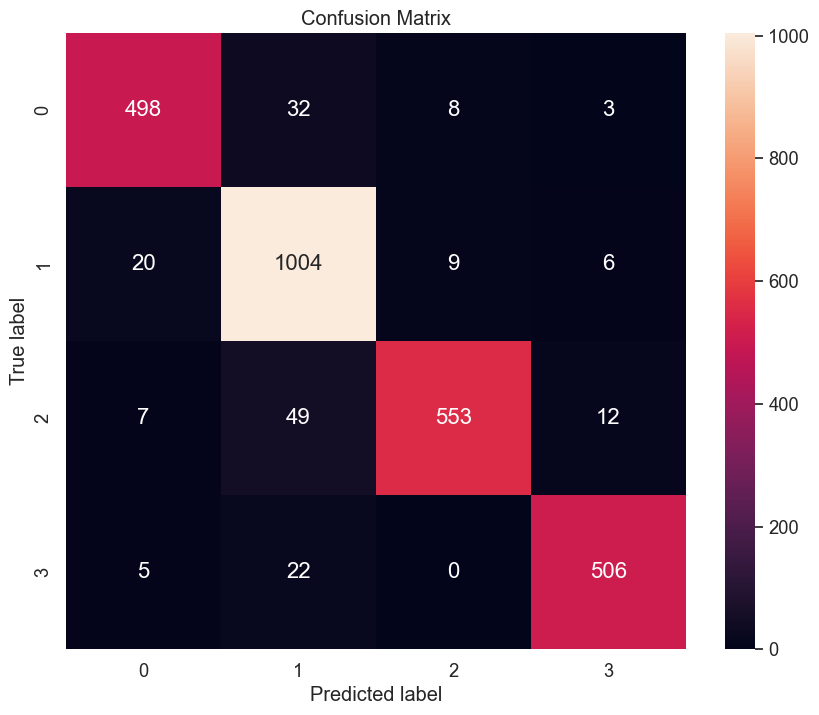

In [14]:
# Prediction and evaluation on test set
naive_bayes_model.fit(X_train_tfidf_selected, y_train)
y_test_pred = naive_bayes_model.predict(X_test_tfidf_selected)
score_test = accuracy_score(y_test, y_test_pred)
print(pd.Series({"Test accuracy": score_test}).to_string())
print(" ")
conf_mat(y_test, y_test_pred, figsize = (10, 8), font_scale = 1.2, annot_kws_size = 16) # Confusion matrix
print(" ")

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred)

array([[ 498,   32,    8,    3],
       [  20, 1004,    9,    6],
       [   7,   49,  553,   12],
       [   5,   22,    0,  506]], dtype=int64)